In [3]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline

# Set the task and experiment type
task_name = 'maptask'
base_url = 'https://raw.github.com/NathanDuran/Maptask-Corpus/master/maptask_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [4]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
21        gru        1200  58.872602     0.237911
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_micro  f1_micro_std
19        gru         800  60.815372      0.828933  0.608617      0.007864


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,600,57.700522,0.205082,1600,59.327587,0.673426,0.594098,0.006662
1,dcnn,600,56.076386,0.321341,600,59.194685,0.484078,0.592759,0.004803
2,gru,1200,58.872602,0.237911,800,60.815372,0.828933,0.608617,0.007864
3,lstm,800,55.875112,0.381871,800,60.316810,0.468755,0.603910,0.004711
4,rcnn,800,58.163241,0.242606,800,60.284482,0.437835,0.603186,0.004474
5,text cnn,200,56.597583,0.332002,1400,59.301722,0.500288,0.593121,0.005173


Plot accuracy of each model per vocabulary size.

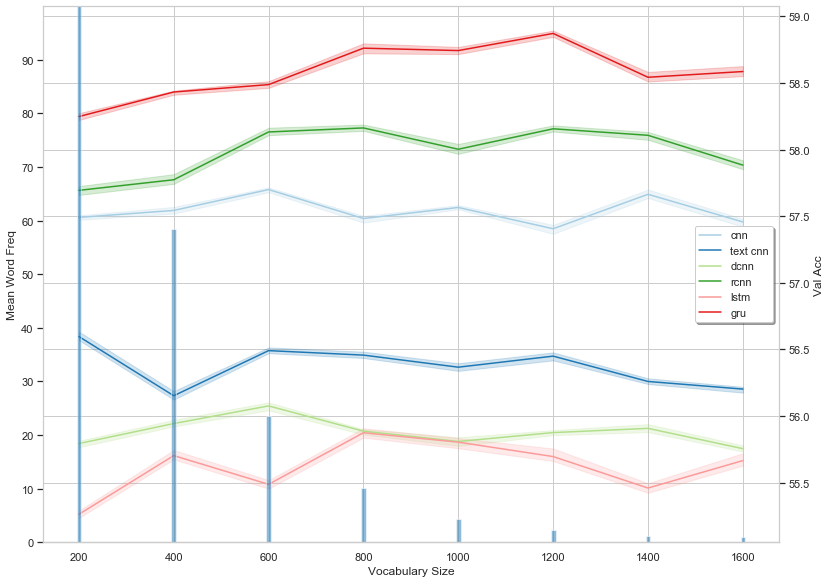

In [5]:
# TODO remove test data
# Get test and validation accuracy for each model
# vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# g, fig = plot_relplot(vocab_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:1600]
ind_start, ind_end = 0, 200
freq_dict = dict()
for i in range(8):
    freq_dict[ind_end] = word_freq.loc[ind_start:ind_end].mean() # Binning
    # freq_dict[ind_end] = word_freq.loc[0:ind_end].sum() # Cumulative summing
    ind_start += 200
    ind_end += 200
word_freq = pd.DataFrame.from_dict(freq_dict, orient='index')
word_freq.reset_index(level=0, inplace=True)
word_freq.rename(columns={'index': 'vocab_size'}, inplace=True)

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, word_freq, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=10, bar_axis_range=[0, 100], bar_width=10,
                          bar_y_label='Mean Word Freq', bar_alpha=0.5, bar_color='tab:blue', legend_loc='best', num_legend_col=1)
# fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different vocabulary size groups.

In [6]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

All models vocab_size are normally distributed.
All models vocab_size have equal variance.
The following models do not have significant p-values when comparing vocab_size groups.
        sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq
cnn   0.723056  7.0  0.103294  1.392605  0.221727  0.119247  0.033212
dcnn  0.713933  7.0  0.101990  1.403204  0.217392  0.120046  0.034078


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.723056,7.0,0.103294,1.392605,0.221727,0.119247,0.033212
text cnn,1.679138,7.0,0.239877,2.805677,0.012192,0.214315,0.136440
dcnn,0.713933,7.0,0.101990,1.403204,0.217392,0.120046,0.034078
rcnn,2.374514,7.0,0.339216,3.132326,0.006056,0.233441,0.157241
lstm,2.847214,7.0,0.406745,2.437593,0.026717,0.191585,0.111734
gru,2.866167,7.0,0.409452,4.014275,0.000924,0.280719,0.208704


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

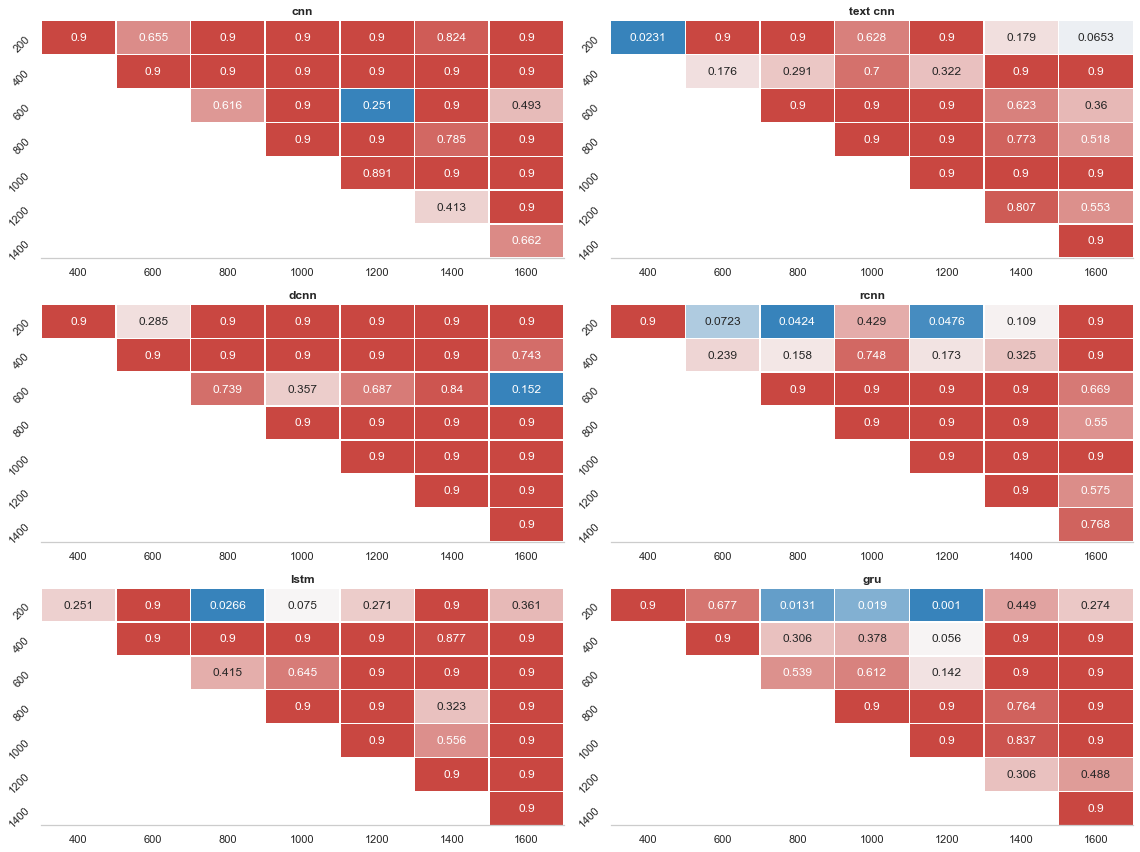

In [7]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 5000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [8]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
27        gru              30  58.677818     0.254389
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_micro  f1_micro_std
26        gru              25  60.872844      0.415885  0.608798      0.004192


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,25,57.491556,0.263350,35,59.484913,0.514620,0.595366,0.005433
1,dcnn,25,56.141233,0.243263,20,59.277298,0.442291,0.593193,0.004385
2,gru,30,58.677818,0.254389,25,60.872844,0.415885,0.608798,0.004192
3,lstm,10,57.976544,0.257621,50,60.178161,0.658406,0.602353,0.006754
4,rcnn,25,58.132309,0.263509,25,60.214799,0.642516,0.602643,0.006468
5,text cnn,40,56.401361,0.331929,55,59.283763,0.314875,0.592940,0.003252


Plot accuracy of each model per sequence length.

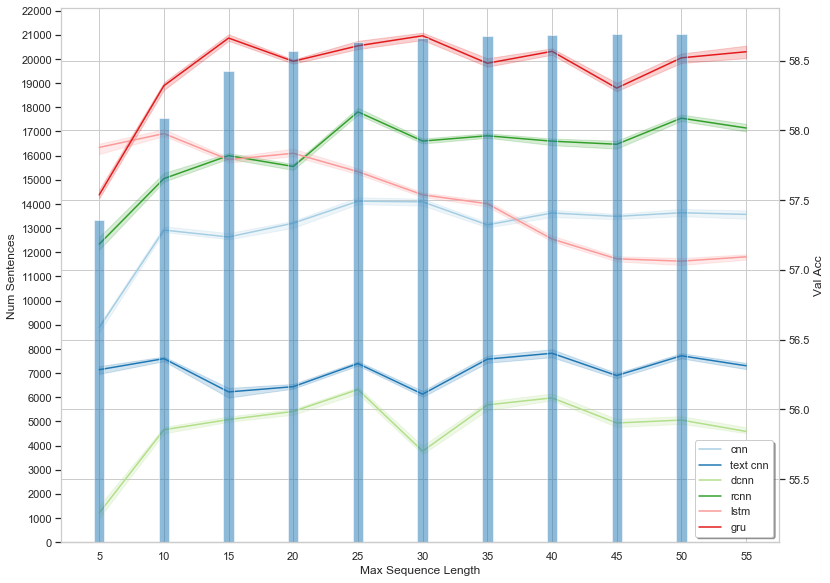

In [9]:
# TODO remove test data
# Get test and validation accuracy for each model
# seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])
#
# g, fig = plot_relplot(seq_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci=16,
#                       title='', y_label='Accuracy', x_label='Sequence Length',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Bin into same values as experiment
ind_start, ind_end = 0, 5
freq_dict = dict()
for i in range(10):
    # freq_dict[ind_end] = sent_lengths.loc[ind_start:ind_end].sum()
    freq_dict[ind_end] = sent_lengths.loc[0:ind_end].sum() # Cumulative sum
    ind_start += 5
    ind_end += 5
sent_lengths = pd.DataFrame.from_dict(freq_dict, orient='index')
sent_lengths.reset_index(level=0, inplace=True)
sent_lengths.rename(columns={'index': 'max_seq_length', 0: 'Count'}, inplace=True)

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sent_lengths, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=1000, bar_axis_range=None, bar_width=0.8,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue', legend_loc='lower right', num_legend_col=1)
# fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different sequence length groups.

In [10]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

The following max_seq_length are not normally distributed.
   model_name max_seq_length    t-stat   p-value
3         cnn             20  0.829943  0.033408
32       dcnn             55  0.821119  0.026144
All models max_seq_length have equal variance.
The following models do not have significant p-values when comparing max_seq_length groups.
            sum_sq    df   mean_sq         F    PR(>F)    eta_sq  omega_sq
text cnn  1.110638  10.0  0.111064  1.708438  0.089189  0.147172  0.060507


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,6.276159,10.0,0.627616,8.511644,7.011400e-10,0.462297,0.405779
text cnn,1.110638,10.0,0.111064,1.708438,8.918859e-02,0.147172,0.060507
dcnn,5.700809,10.0,0.570081,6.206835,2.631651e-07,0.385354,0.321274
rcnn,6.842838,10.0,0.684284,8.807070,3.418396e-10,0.470788,0.415114
lstm,12.209577,10.0,1.220958,18.727790,8.659686e-19,0.654182,0.617096
gru,10.225389,10.0,1.022539,10.653614,4.680829e-12,0.518333,0.467406


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

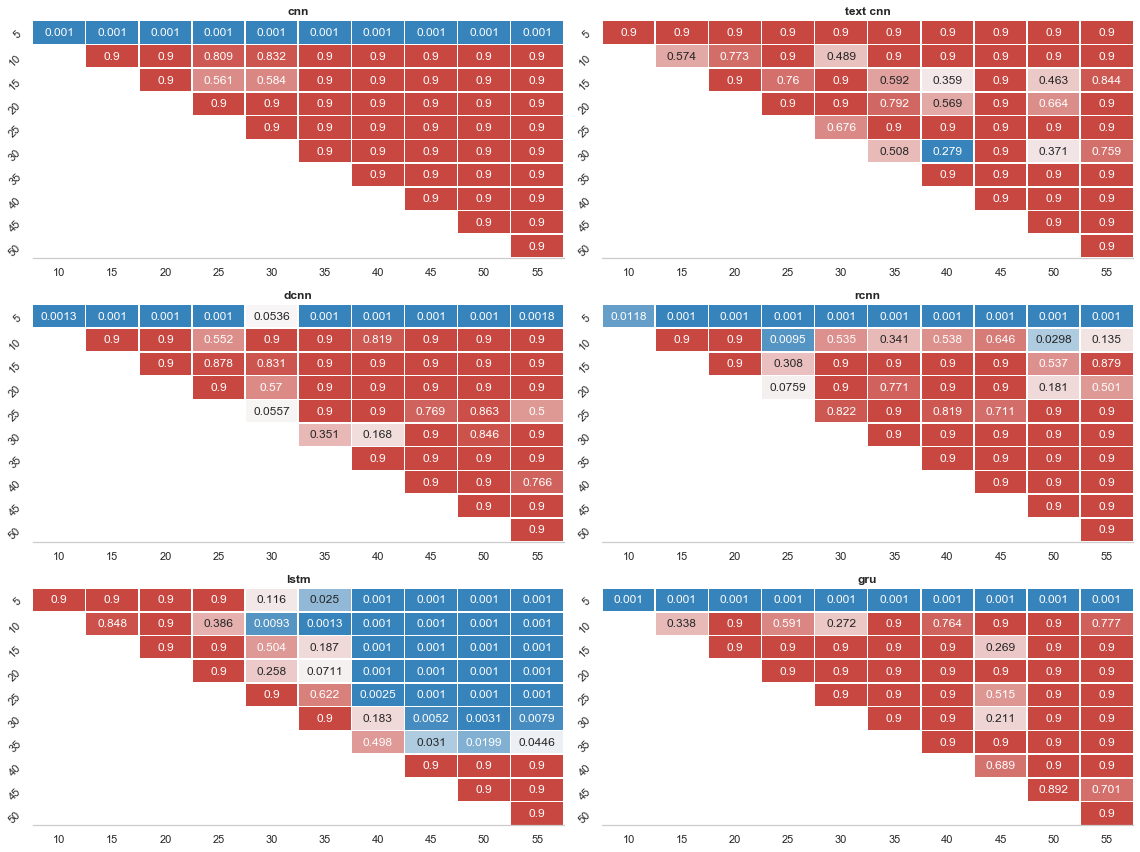

In [11]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Input Sequence Combinations

Compare vocabulary size (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens).

In [12]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))
inseq_mean_data.drop(inseq_mean_data[inseq_mean_data.vocab_size == 600].index, inplace=True)
inseq_data.drop(inseq_data[inseq_data.vocab_size == 600].index, inplace=True)
# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max

Best validation accuracy in mean data:
   model_name  vocab_size  max_seq_length    val_acc  val_acc_std
10        gru         800              50  58.587316     0.314054
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length  test_acc  test_acc_std  f1_micro  f1_micro_std
10        gru         800              50  60.67816      0.520228  0.606915      0.005397


,model_name,vocab_size,max_seq_length,val_acc,val_acc_std,vocab_size,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,400,25,57.715008,0.229754,1700,115,59.285919,0.526212,0.593519,0.004982
1,dcnn,800,50,56.105340,0.263390,1700,115,58.856321,0.544365,0.589428,0.005180
2,gru,800,50,58.587316,0.314054,800,50,60.678160,0.520228,0.606915,0.005397
3,lstm,400,25,57.473550,0.245811,800,50,59.900143,0.782540,0.599710,0.007357
4,rcnn,1700,115,58.045479,0.230744,1700,115,59.850575,0.573052,0.598733,0.005763
5,text cnn,1700,115,56.328886,0.276422,800,50,59.195402,0.407230,0.592288,0.003927


Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA comparing vocabulary size (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens) for each model.

In [13]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 400) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 800) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 1700) & (inseq_data['max_seq_length'] == 115)]
choices = ['V=600_S=25', 'V=800_S=50', 'V=1.7k_S=115']#'V=800_S=50',
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(inseq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(inseq_data, exp_param, metric)

# Run t-test
# t_test(inseq_data, exp_param, metric)

All models exp_params are normally distributed.
The following models exp_params do not have equal variance.
  model_name  exp_params    t-stat   p-value
4       lstm         NaN  5.547946  0.009584
The following models do not have significant p-values when comparing exp_params groups.
            sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq
text cnn  0.039417  2.0  0.019709  0.369551  0.694486  0.026645 -0.043874
rcnn      0.329553  2.0  0.164776  2.978368  0.067790  0.180744  0.116523
gru       0.395336  2.0  0.197668  2.420182  0.107946  0.152020  0.086490


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.538149,2.0,0.269074,4.282784,2.423870e-02,0.240839,0.179556
text cnn,0.039417,2.0,0.019709,0.369551,6.944862e-01,0.026645,-0.043874
dcnn,0.548540,2.0,0.274270,4.085843,2.817103e-02,0.232337,0.170622
rcnn,0.329553,2.0,0.164776,2.978368,6.778978e-02,0.180744,0.116523
lstm,16.328238,2.0,8.164119,115.129413,6.073122e-14,0.895047,0.883837
gru,0.395336,2.0,0.197668,2.420182,1.079463e-01,0.152020,0.086490


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

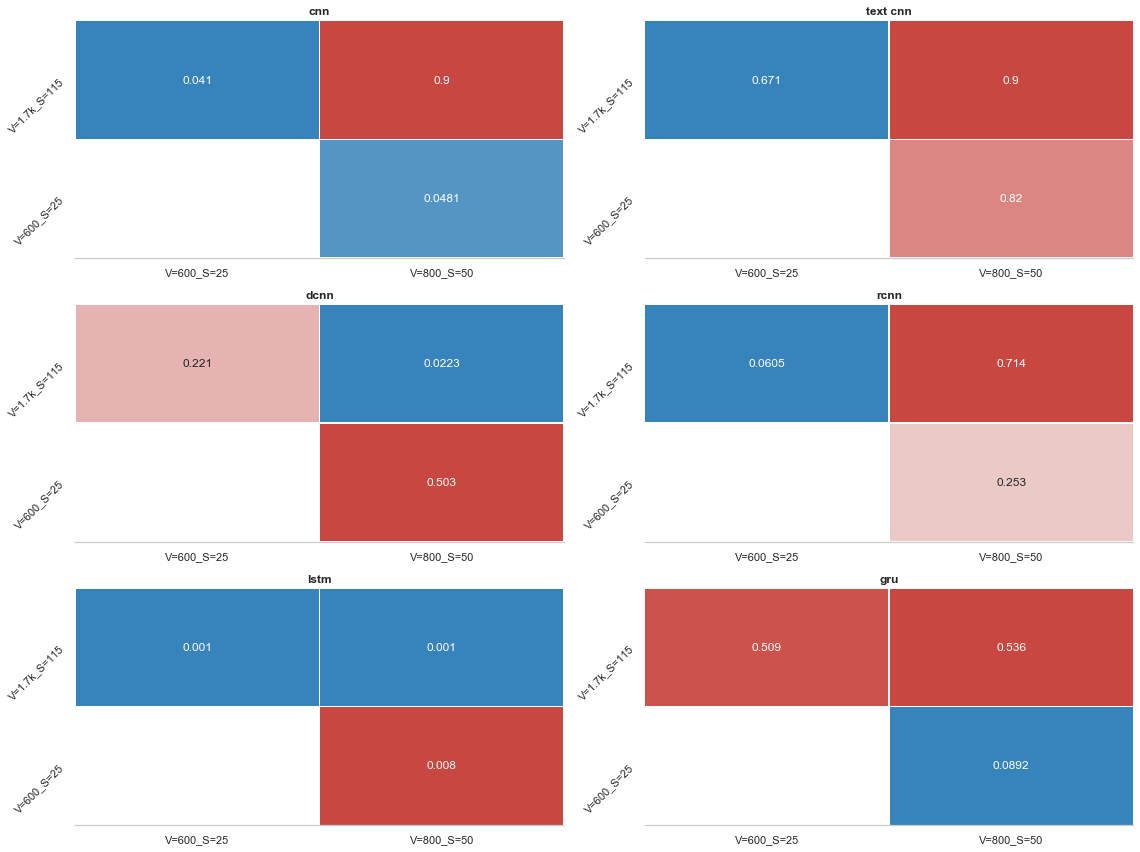

In [14]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param , exp_param + '_anova.png'))

# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in range [100, 300].

In [15]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max

Best validation accuracy in mean data:
   model_name embedding_type  embedding_dim    val_acc  val_acc_std
52        gru           deps            200  59.462143      0.23394
Best test accuracy in mean data:
    model_name embedding_type  embedding_dim  test_acc  test_acc_std  f1_micro  f1_micro_std
149   text cnn       word2vec            300   61.7227      0.411471  0.617524      0.003974


,model_name,embedding_type,embedding_dim,val_acc,val_acc_std,embedding_type,embedding_dim,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,fasttext,300,57.882185,0.201011,fasttext,150,59.533764,0.739143,0.596017,0.006880
1,dcnn,fasttext,250,57.372045,0.314543,numberbatch,300,59.708332,0.650417,0.597538,0.006327
2,gru,deps,200,59.462143,0.233940,numberbatch,200,61.615659,0.486723,0.616365,0.004962
3,lstm,glove,300,57.932374,0.283561,glove,300,60.410920,0.579422,0.604779,0.005801
4,rcnn,deps,100,59.449875,0.241694,word2vec,200,61.008620,0.435707,0.610644,0.004412
5,text cnn,fasttext,300,58.966856,0.235203,word2vec,300,61.722700,0.411471,0.617524,0.003974


Plot accuracy of each model per embedding type and dimension.

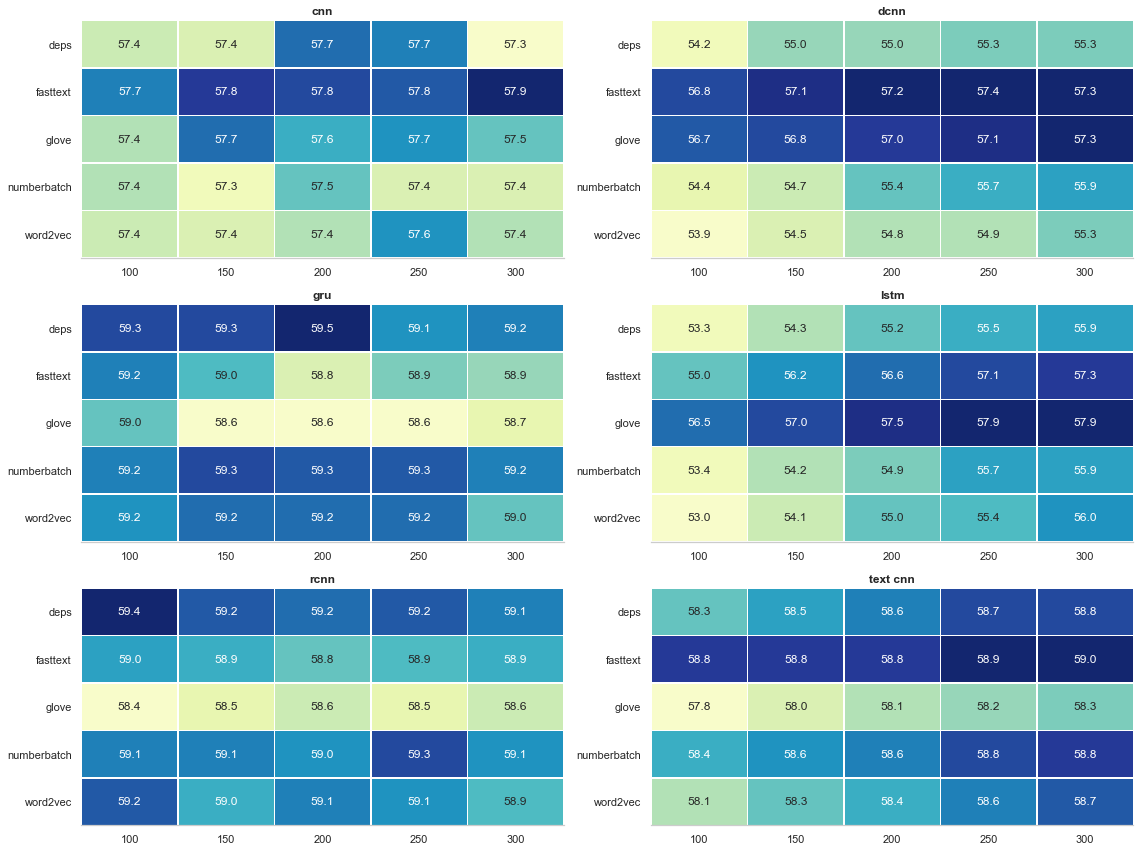

In [16]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
# g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform Two-way ANOVA for each model, comparing different embedding type and dimension groups.

In [17]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Levene test for equal variance
levene_test(embed_data, 'embedding_params', metric)

# Run Two-way ANOVA
two_way_anova_test(embed_data, 'embedding_dim', 'embedding_type', metric, show_result=True)

The following embedding_params are not normally distributed.
    model_name embedding_params    t-stat   p-value
0          cnn        glove_100  0.724160  0.001730
46    text cnn         deps_100  0.835564  0.039036
80        rcnn     word2vec_200  0.759798  0.004697
91        rcnn     word2vec_300  0.791048  0.011284
93        rcnn        glove_150  0.840905  0.045239
106       lstm  numberbatch_250  0.815921  0.022620
121       lstm     fasttext_150  0.831388  0.034773
128        gru  numberbatch_200  0.844072  0.049363
136        gru         deps_250  0.803581  0.016026
143        gru  numberbatch_100  0.812123  0.020346
145        gru     word2vec_200  0.749421  0.003511
The following models embedding_params do not have equal variance.
  model_name  embedding_params    t-stat   p-value
1   text cnn               NaN  1.602996  0.041665
The following models do not have significant p-values when comparing embedding_dim and embedding_type groups.
   model_name                        

,model_name,exp_params,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
0,cnn,C(embedding_dim),0.800259,4.0,0.200065,2.584365,3.794887e-02,0.032745,0.020011
1,cnn,C(embedding_type),4.315420,4.0,1.078855,13.936256,3.576774e-10,0.176581,0.163393
2,cnn,C(embedding_dim):C(embedding_type),1.905054,16.0,0.119066,1.538050,8.800104e-02,0.077952,0.027184
3,text cnn,C(embedding_dim),5.461606,4.0,1.365402,29.794990,6.819204e-20,0.165088,0.159327
4,text cnn,C(embedding_type),16.612361,4.0,4.153090,90.626288,9.002979e-46,0.502143,0.495915
5,text cnn,C(embedding_dim):C(embedding_type),0.698005,16.0,0.043625,0.951965,5.106897e-01,0.021099,-0.001063
6,dcnn,C(embedding_dim),32.270524,4.0,8.067631,50.741885,2.099171e-30,0.091796,0.089946
7,dcnn,C(embedding_type),276.334534,4.0,69.083633,434.505962,1.475799e-104,0.786055,0.783891
8,dcnn,C(embedding_dim):C(embedding_type),7.167647,16.0,0.447978,2.817586,3.509542e-04,0.020389,0.013147
9,rcnn,C(embedding_dim),0.340741,4.0,0.085185,1.109144,3.530060e-01,0.009948,0.000977


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

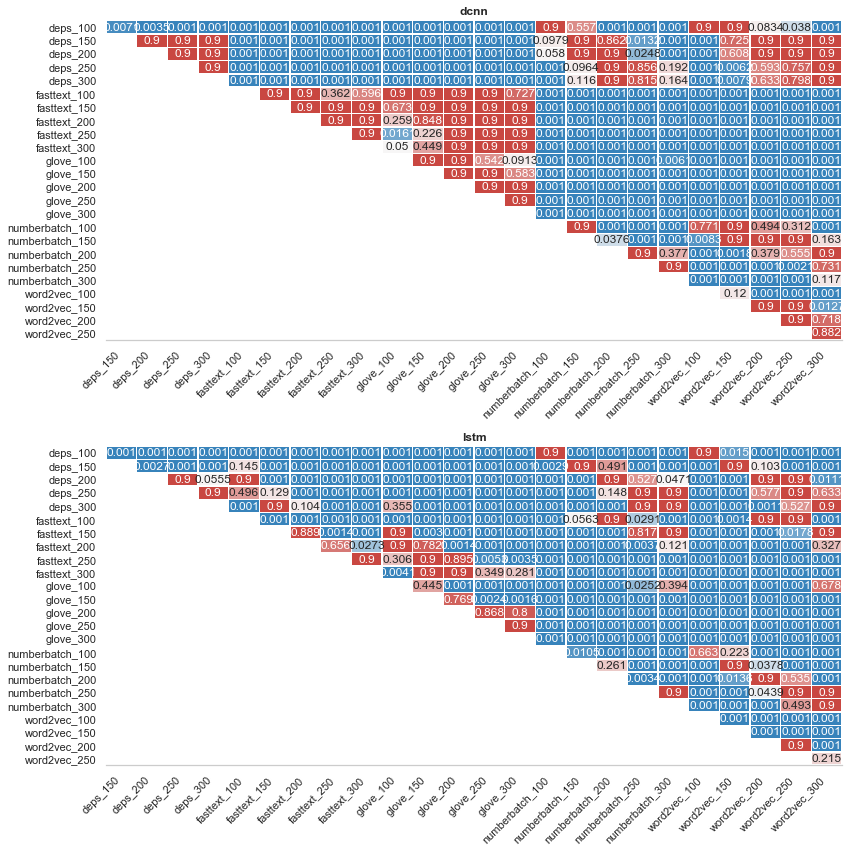

In [18]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(embed_data, 'embedding_params', metric, show_result=False)

# Just get the models where there is a significant difference
tukey_frame = tukey_frame.loc[(tukey_frame['model_name'] == 'dcnn') | (tukey_frame['model_name'] == 'lstm')]

# Generate heatmap
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=1, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=0, x_tick_rotation=45)
# g.savefig(os.path.join(task_name, 'embedding_type' ,'embedding_type_anova.png'))

# Input sequence and embeddings final results

In [25]:
# Name of the experiment parameter for comparison
exp_param = 'input_seq_final'

# Load language models experiment data
inseq_final_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
inseq_final_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_final_data_max = get_max(inseq_final_mean_data, [])
inseq_final_data_max

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
4       rcnn  58.731445     0.202454
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_micro  f1_micro_std
2        gru  61.121407      0.638604  0.611224      0.006715


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,57.575298,0.236155,59.217673,1.009346,0.592831,0.010144
1,dcnn,57.726037,0.389426,59.958333,0.580468,0.599819,0.005686
2,gru,58.494626,0.356901,61.121408,0.638604,0.611224,0.006715
3,lstm,58.152690,0.151386,59.863505,0.624086,0.599022,0.006334
4,rcnn,58.731445,0.202454,60.433187,0.619327,0.604526,0.006102
5,text cnn,58.538321,0.244092,60.242097,0.633481,0.602679,0.006479


# TODO Attentional / multi-layer models / CRF

# Language Models

Using pre-trained language models to generate sequence representations.

In [26]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max

Best validation accuracy in mean data:
  model_name   val_acc  val_acc_std
4      xlnet  61.20519     0.508708
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_micro  f1_micro_std
0       bert  62.907314      0.324844  0.629001      0.003265


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bert,61.119836,0.441585,62.907314,0.324844,0.629001,0.003265
1,roberta,61.184705,0.398299,62.632151,0.238610,0.626285,0.002376
2,gpt2,60.177535,0.281629,61.042722,0.982383,0.610536,0.009902
3,dialogpt,57.036532,1.832725,56.698045,1.851647,0.566908,0.018445
4,xlnet,61.205190,0.508708,61.611152,0.781022,0.616112,0.007810
5,convert,58.158563,0.213715,60.938217,0.626327,0.609377,0.006339
6,elmo,58.337525,0.214448,60.444682,0.354509,0.604562,0.003530
7,use,59.354739,0.216396,60.671694,0.560511,0.606770,0.005473
8,mlstm char lm,58.495166,0.272745,60.787355,0.626975,0.607857,0.006284
9,nnlm,52.440483,0.183359,56.648706,0.239134,0.567017,0.002410


Plot accuracy of each language model.

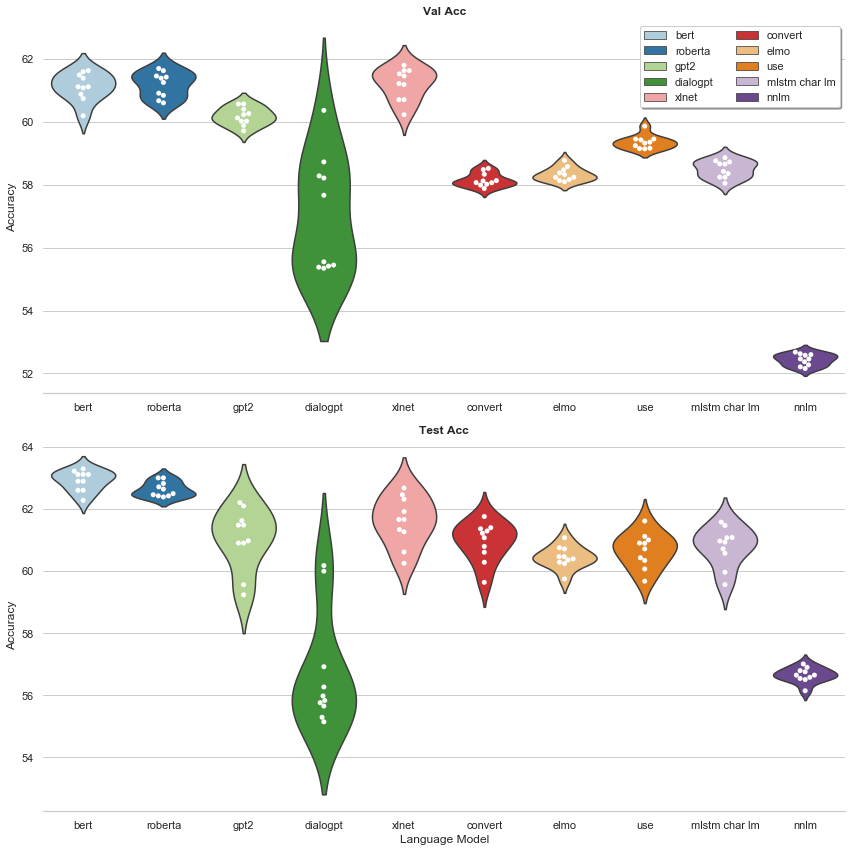

In [27]:
# TODO remove test data
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)
# g.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))
